# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_percolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 10, 10
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['block_16_project_BN']
    LAST_LAYER = 'block_16_project_BN'
    PREPROCESSING = tf.keras.applications.mobilenet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8314 - accuracy: 0.7278

947/947 [==============================] - 3708s 4s/step - loss: 0.8314 - accuracy: 0.7278 - val_loss: 6.5792 - val_accuracy: 0.6641
Epoch 2/200
947/947 [==============================] - ETA: 0s - loss: 0.7103 - accuracy: 0.7568

947/947 [==============================] - 3454s 4s/step - loss: 0.7103 - accuracy: 0.7568 - val_loss: 3.0319 - val_accuracy: 0.6240
Epoch 3/200
947/947 [==============================] - ETA: 0s - loss: 0.6690 - accuracy: 0.7703

947/947 [==============================] - 3516s 4s/step - loss: 0.6690 - accuracy: 0.7703 - val_loss: 1.8182 - val_accuracy: 0.6924
Epoch 4/200
947/947 [==============================] - 3243s 3s/step - loss: 0.6381 - accuracy: 0.7771 - val_loss: 1.9199 - val_accuracy: 0.6845
Epoch 5/200
947/947 [==============================] - 3247s 3s/step - loss: 0.6132 - accuracy: 0.7859 - val_loss: 3.0795 - val_accuracy: 0.6390
Epoch 6/200
947/947 [==============================] - ETA: 0s - loss: 0.5946 - accuracy: 0.7886

947/947 [==============================] - 3495s 4s/step - loss: 0.5946 - accuracy: 0.7886 - val_loss: 1.4484 - val_accuracy: 0.6339
Epoch 7/200
947/947 [==============================] - ETA: 0s - loss: 0.5699 - accuracy: 0.7997

947/947 [==============================] - 3487s 4s/step - loss: 0.5699 - accuracy: 0.7997 - val_loss: 1.3426 - val_accuracy: 0.7193
Epoch 8/200
947/947 [==============================] - 3253s 3s/step - loss: 0.5649 - accuracy: 0.7992 - val_loss: 1.3735 - val_accuracy: 0.5884
Epoch 9/200
947/947 [==============================] - 3249s 3s/step - loss: 0.5523 - accuracy: 0.8047 - val_loss: 1.5406 - val_accuracy: 0.6419
Epoch 10/200
947/947 [==============================] - ETA: 0s - loss: 0.5413 - accuracy: 0.8096

947/947 [==============================] - 3449s 4s/step - loss: 0.5413 - accuracy: 0.8096 - val_loss: 0.9419 - val_accuracy: 0.7649
Epoch 11/200
947/947 [==============================] - 3246s 3s/step - loss: 0.5248 - accuracy: 0.8139 - val_loss: 1.2622 - val_accuracy: 0.7162
Epoch 12/200
947/947 [==============================] - 3276s 3s/step - loss: 0.5178 - accuracy: 0.8158 - val_loss: 0.9463 - val_accuracy: 0.7069
Epoch 13/200
947/947 [==============================] - 3248s 3s/step - loss: 0.5023 - accuracy: 0.8225 - val_loss: 1.3195 - val_accuracy: 0.6314
Epoch 14/200
947/947 [==============================] - 3244s 3s/step - loss: 0.5027 - accuracy: 0.8226 - val_loss: 2.2212 - val_accuracy: 0.5183
Epoch 15/200
947/947 [==============================] - ETA: 0s - loss: 0.4867 - accuracy: 0.8254

947/947 [==============================] - 3461s 4s/step - loss: 0.4867 - accuracy: 0.8254 - val_loss: 0.8050 - val_accuracy: 0.7719
Epoch 16/200
947/947 [==============================] - 3249s 3s/step - loss: 0.4777 - accuracy: 0.8295 - val_loss: 0.8993 - val_accuracy: 0.7251
Epoch 17/200
947/947 [==============================] - ETA: 0s - loss: 0.4735 - accuracy: 0.8313

947/947 [==============================] - 3460s 4s/step - loss: 0.4735 - accuracy: 0.8313 - val_loss: 0.6506 - val_accuracy: 0.7962
Epoch 18/200
947/947 [==============================] - 3246s 3s/step - loss: 0.4624 - accuracy: 0.8351 - val_loss: 0.6974 - val_accuracy: 0.7792
Epoch 19/200
947/947 [==============================] - 3245s 3s/step - loss: 0.4598 - accuracy: 0.8365 - val_loss: 0.7239 - val_accuracy: 0.7739
Epoch 20/200
947/947 [==============================] - 3246s 3s/step - loss: 0.4496 - accuracy: 0.8408 - val_loss: 0.6983 - val_accuracy: 0.7760
Epoch 21/200
947/947 [==============================] - 3248s 3s/step - loss: 0.4411 - accuracy: 0.8425 - val_loss: 0.8862 - val_accuracy: 0.7276
Epoch 22/200
947/947 [==============================] - 3243s 3s/step - loss: 0.4364 - accuracy: 0.8437 - val_loss: 0.7405 - val_accuracy: 0.7685
Epoch 23/200
947/947 [==============================] - 3245s 3s/step - loss: 0.4295 - accuracy: 0.8477 - val_loss: 1.1044 - val_accuracy

947/947 [==============================] - 3437s 4s/step - loss: 0.4000 - accuracy: 0.8561 - val_loss: 0.6423 - val_accuracy: 0.8048
Epoch 29/200
947/947 [==============================] - 3251s 3s/step - loss: 0.3909 - accuracy: 0.8589 - val_loss: 7.8751 - val_accuracy: 0.2393
Epoch 30/200
947/947 [==============================] - 3240s 3s/step - loss: 0.3872 - accuracy: 0.8607 - val_loss: 2.0708 - val_accuracy: 0.6913
Epoch 31/200
947/947 [==============================] - 3249s 3s/step - loss: 0.3824 - accuracy: 0.8626 - val_loss: 0.6909 - val_accuracy: 0.7970
Epoch 32/200
947/947 [==============================] - ETA: 0s - loss: 0.3748 - accuracy: 0.8643

947/947 [==============================] - 3449s 4s/step - loss: 0.3748 - accuracy: 0.8643 - val_loss: 0.6109 - val_accuracy: 0.7844
Epoch 33/200
947/947 [==============================] - 3253s 3s/step - loss: 0.3689 - accuracy: 0.8676 - val_loss: 0.7602 - val_accuracy: 0.7906
Epoch 34/200
947/947 [==============================] - 3250s 3s/step - loss: 0.3625 - accuracy: 0.8669 - val_loss: 0.6796 - val_accuracy: 0.7971
Epoch 35/200
947/947 [==============================] - 3252s 3s/step - loss: 0.3584 - accuracy: 0.8704 - val_loss: 1.7119 - val_accuracy: 0.5011
Epoch 36/200
947/947 [==============================] - 3249s 3s/step - loss: 0.3555 - accuracy: 0.8715 - val_loss: 0.8294 - val_accuracy: 0.7646
Epoch 37/200
947/947 [==============================] - 3246s 3s/step - loss: 0.3483 - accuracy: 0.8735 - val_loss: 0.8106 - val_accuracy: 0.7838
Epoch 38/200
947/947 [==============================] - 3242s 3s/step - loss: 0.3464 - accuracy: 0.8742 - val_loss: 0.9709 - val_accuracy

947/947 [==============================] - 3436s 4s/step - loss: 0.3391 - accuracy: 0.8772 - val_loss: 0.5636 - val_accuracy: 0.8220
Epoch 40/200
947/947 [==============================] - 3250s 3s/step - loss: 0.3327 - accuracy: 0.8766 - val_loss: 0.6458 - val_accuracy: 0.8060
Epoch 41/200
947/947 [==============================] - 3244s 3s/step - loss: 0.3299 - accuracy: 0.8796 - val_loss: 0.6488 - val_accuracy: 0.8013
Epoch 42/200
947/947 [==============================] - 3525s 4s/step - loss: 0.3266 - accuracy: 0.8812 - val_loss: 0.6009 - val_accuracy: 0.7990
Epoch 43/200
947/947 [==============================] - 3964s 4s/step - loss: 0.3188 - accuracy: 0.8826 - val_loss: 1.0841 - val_accuracy: 0.7506
Epoch 44/200
947/947 [==============================] - 3796s 4s/step - loss: 0.3146 - accuracy: 0.8834 - val_loss: 0.9775 - val_accuracy: 0.7360
Epoch 45/200
947/947 [==============================] - 3813s 4s/step - loss: 0.3146 - accuracy: 0.8863 - val_loss: 0.7432 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 435s 3s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9710036974064178,
 'basal cell carcinoma': 0.9850648273467064,
 'dermatofibroma': 0.9694903086862886,
 'melanoma': 0.9221828266190197,
 'nevus': 0.956614775213983,
 'pigmented benign keratosis': 0.985566213194575,
 'seborrheic keratosis': 0.9425834970530451,
 'solar lentigo': 0.9476373099575401,
 'squamous cell carcinoma': 0.9548917414874347,
 'vascular lesion': 0.9970903649513675}

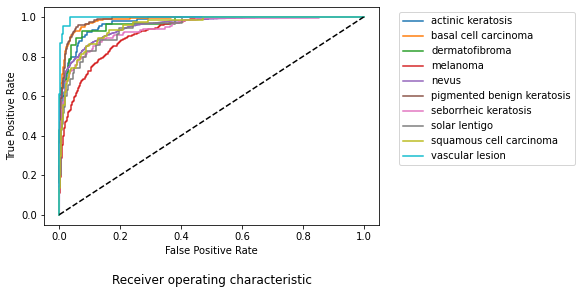

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

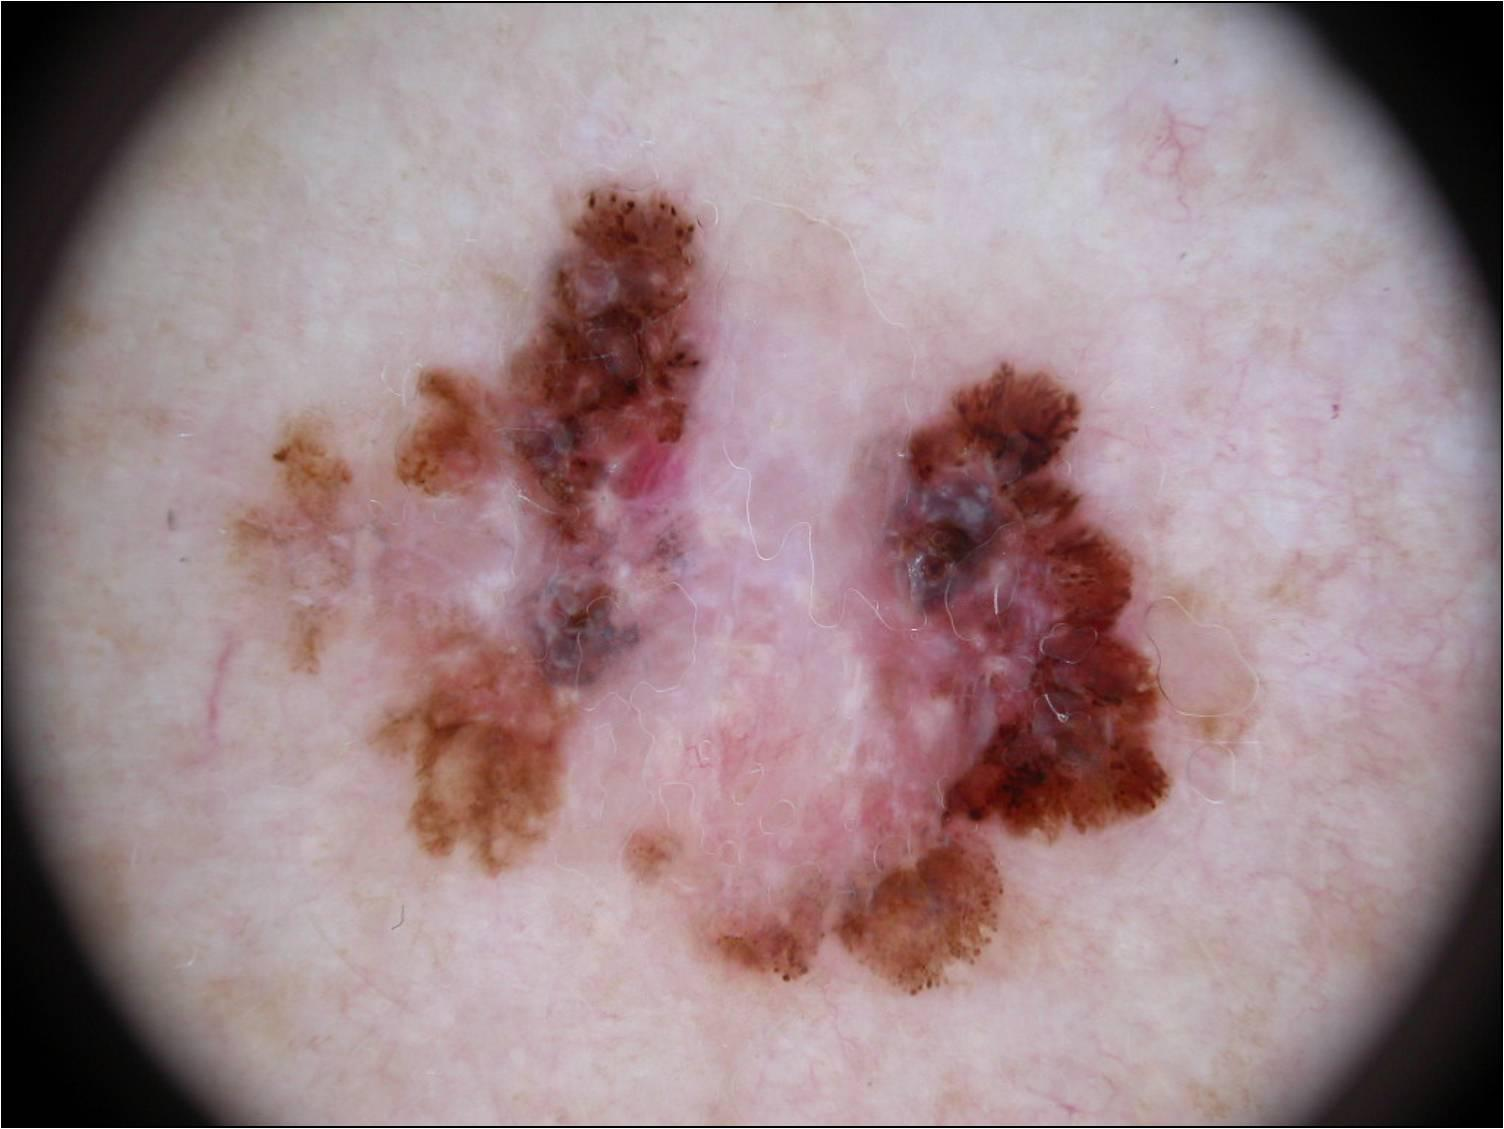

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

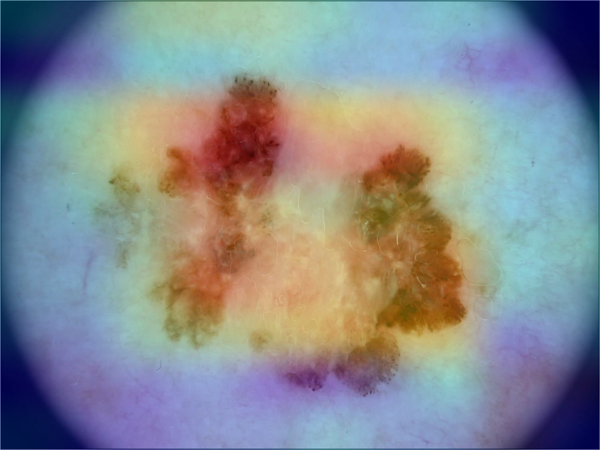

In [23]:
display_gradcam(melanoma_im_path, heatmap)